In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Import datasets
path=r'/Users/elvachen/Documents/DA Learning/Immersion-Exercise/6/2original data'
df_vp=pd.read_csv(os.path.join(path,'vehicle_population.csv'),index_col = False)
df_zev=pd.read_csv(os.path.join(path,'new_zev_sales.csv'),index_col = False)
df_gd=pd.read_csv(os.path.join(path,'gasoline_diesel.csv'),index_col = False)
df_cp=pd.read_csv(os.path.join(path,'cal_population.csv'),index_col = False)

### Aggregate, derive and merge data as needed

In [3]:
# Derive column 'car_type' for df_vp

def car_type(row):
  if (row['fuel_type']=='Electric') or (row['fuel_type']=='PHEV'):
    return 'ZEV'
  else: return 'non-ZEV'
df_vp['car_type'] = df_vp.apply(car_type, axis=1)
df_vp.head()

,Unnamed: 0,year,county,fuel_type,make,model,num_vehicle,car_type
0,0,2010,Alameda,Diesel,NaN,NaN,10939,non-ZEV
1,1,2010,Alameda,Electric,Ford,Ranger,3,ZEV
2,2,2010,Alameda,Electric,Tesla,Roadster,17,ZEV
3,3,2010,Alameda,Flex Fuel,NaN,NaN,10974,non-ZEV
4,4,2010,Alameda,Gasoline,NaN,NaN,840577,non-ZEV


In [4]:
# Proof the new column 'car_type'
df_vp['car_type'].value_counts(dropna=False)

ZEV        17422
non-ZEV     4465
Name: car_type, dtype: int64

In [5]:
# Aggregate the number of vehicles
df_vp=df_vp.groupby(['year','county','car_type']).agg({'num_vehicle':['sum']}).reset_index()

In [6]:
# Rename columns
df_vp.columns=['year','county','car_type','num_vehicle']

In [9]:
df_vp.head()

,year,county,car_type,num_vehicle
0,2010,Alameda,ZEV,20
1,2010,Alameda,non-ZEV,885402
2,2010,Alpine,non-ZEV,1041
3,2010,Amador,ZEV,1
4,2010,Amador,non-ZEV,30480


In [10]:
# Pivot data
df_vp_pivot=pd.pivot_table(df_vp,index=['year','county'],columns='car_type',aggfunc='sum').reset_index()

In [13]:
# Rename columns
df_vp_pivot.columns=['year','county','zev_pop','non_zev_pop']

In [16]:
# Change the values to 0 for null values in column 'ZEV_pop'
df_vp_pivot['zev_pop'].fillna(0, inplace = True)

In [19]:
# Aggregate the number of vehicles and rename columns
df_zev=df_zev.groupby(['year','county']).agg({'num_vehicle':['sum']}).reset_index()
df_zev.columns=['year','county','zev_sales']

In [22]:
# Calculate the average prices of gasoline and diesel, and rename columns
df_gd=df_gd.groupby('year').agg({'gasoline_price':['mean'],'diesel_price':['mean']}).reset_index()
df_gd.columns=['year','gasoline_price','diesel_price']

In [24]:
# Aggregate population by year and rename columns
df_cp=df_cp.groupby(['year','county']).agg({'population':['sum']}).reset_index()
df_cp.columns=['year','county','population']

In [25]:
# Merge dataframes
df_merged=df_vp_pivot.merge(df_zev, on = ['year','county'],how = 'inner',indicator= False)
df_merged.head()

,year,county,zev_pop,non_zev_pop,zev_sales
0,2010,Alameda,20.0,885402.0,13
1,2010,Amador,1.0,30480.0,1
2,2010,Contra Costa,10.0,666294.0,9
3,2010,Fresno,2.0,481145.0,2
4,2010,Humboldt,2.0,90949.0,1


In [26]:
# Merge dataframes: assume each county had the same fuel prices with the state
df_merged=df_merged.merge(df_gd, on = 'year',how = 'left',indicator= False)
df_merged.head()

,year,county,zev_pop,non_zev_pop,zev_sales,gasoline_price,diesel_price
0,2010,Alameda,20.0,885402.0,13,3.090846,3.157423
1,2010,Amador,1.0,30480.0,1,3.090846,3.157423
2,2010,Contra Costa,10.0,666294.0,9,3.090846,3.157423
3,2010,Fresno,2.0,481145.0,2,3.090846,3.157423
4,2010,Humboldt,2.0,90949.0,1,3.090846,3.157423


In [27]:
# Merge dataframes
df_merged=df_merged.merge(df_cp, on = ['year','county'],how = 'inner',indicator= False)
df_merged.head()

,year,county,zev_pop,non_zev_pop,zev_sales,gasoline_price,diesel_price,population
0,2010,Alameda,20.0,885402.0,13,3.090846,3.157423,1512986
1,2010,Amador,1.0,30480.0,1,3.090846,3.157423,37886
2,2010,Contra Costa,10.0,666294.0,9,3.090846,3.157423,1052540
3,2010,Fresno,2.0,481145.0,2,3.090846,3.157423,932039
4,2010,Humboldt,2.0,90949.0,1,3.090846,3.157423,135009


In [28]:
# Export dataframes
df_merged.to_csv(os.path.join(path, 'merged_by_year.csv'))

### Explore data relationship by using plots

#### Correlation matrix heatmap 

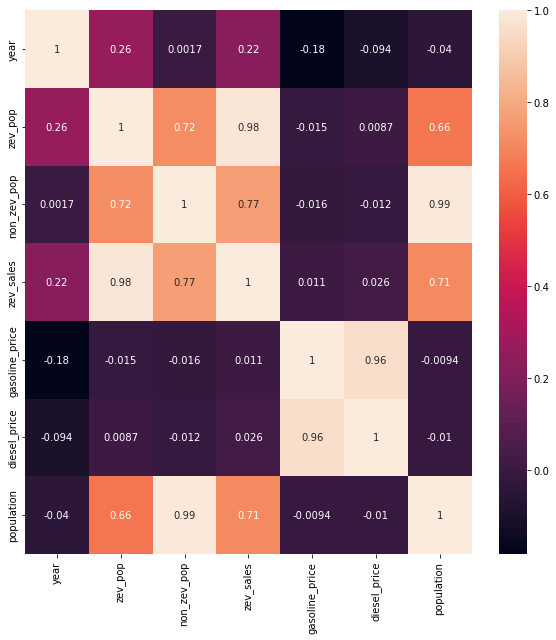

In [29]:
# Create a subplot with matplotlib
f,ax = plt.subplots(figsize=(10,10))

# Create the correlation heatmap in seaborn by applying a heatmap onto the correlation matrix and the subplots defined above.
corr = sns.heatmap(df_merged.corr(), annot = True, ax = ax) # The `annot` argument allows the plot to 
#place the correlation coefficients onto the heatmap.

Above heatmap shows neither vehicle population nor ZEV sales are related to fuel price changes. The relationship between ZEV sales and ZEV population (coefficient=0.98) is very strong but not meaningful, as they have calculative causality. Hence, we should pay attention to non-ZEV population and demographic populatin which have the strongest relationship. Also, ZEV population / ZEV sales have strong relationships with demographic pouplation. It makes sense that they are not as strong as non-ZEV population with demographic populatin, as non-ZEV is still high proportion of vehicle usage. 

#### Scatterplot for ZEV population, sales and California population

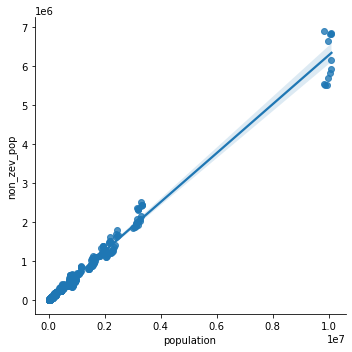

In [31]:
# Create a scatterplot for the "non_zev_pop" and "population" columns in seaborn
sns.lmplot(x = 'population', y = 'non_zev_pop', data = df_merged)

The correlation coefficient between non_ZEV population and California population is high as 0.99. Also, the above satterplot indicates the relationship. All dotsd are staying very closely with the trend line. It means the non_ZEV vehicle poplation must increase when the demographic increase, vice versa.

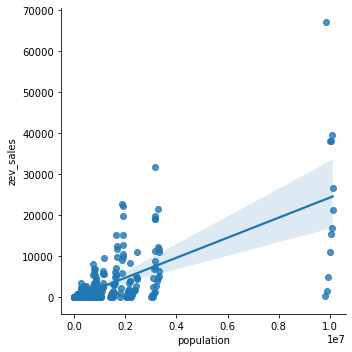

In [33]:
# Create a scatterplot for the "zev_sales" and "population" columns in seaborn
sns.lmplot(x = 'population', y = 'zev_sales', data = df_merged)

The correlation coefficient between ZEV sales and California population is high as 0.71. The above satterplot comparing the non_ZEV population scatterplot also shows different features. Many dots are staying far away from the trend line. It means ZEV sales is correlated to demographic, but not strong as non_ZEV because most of people's choices are still non_ZEV.

### Pair plot

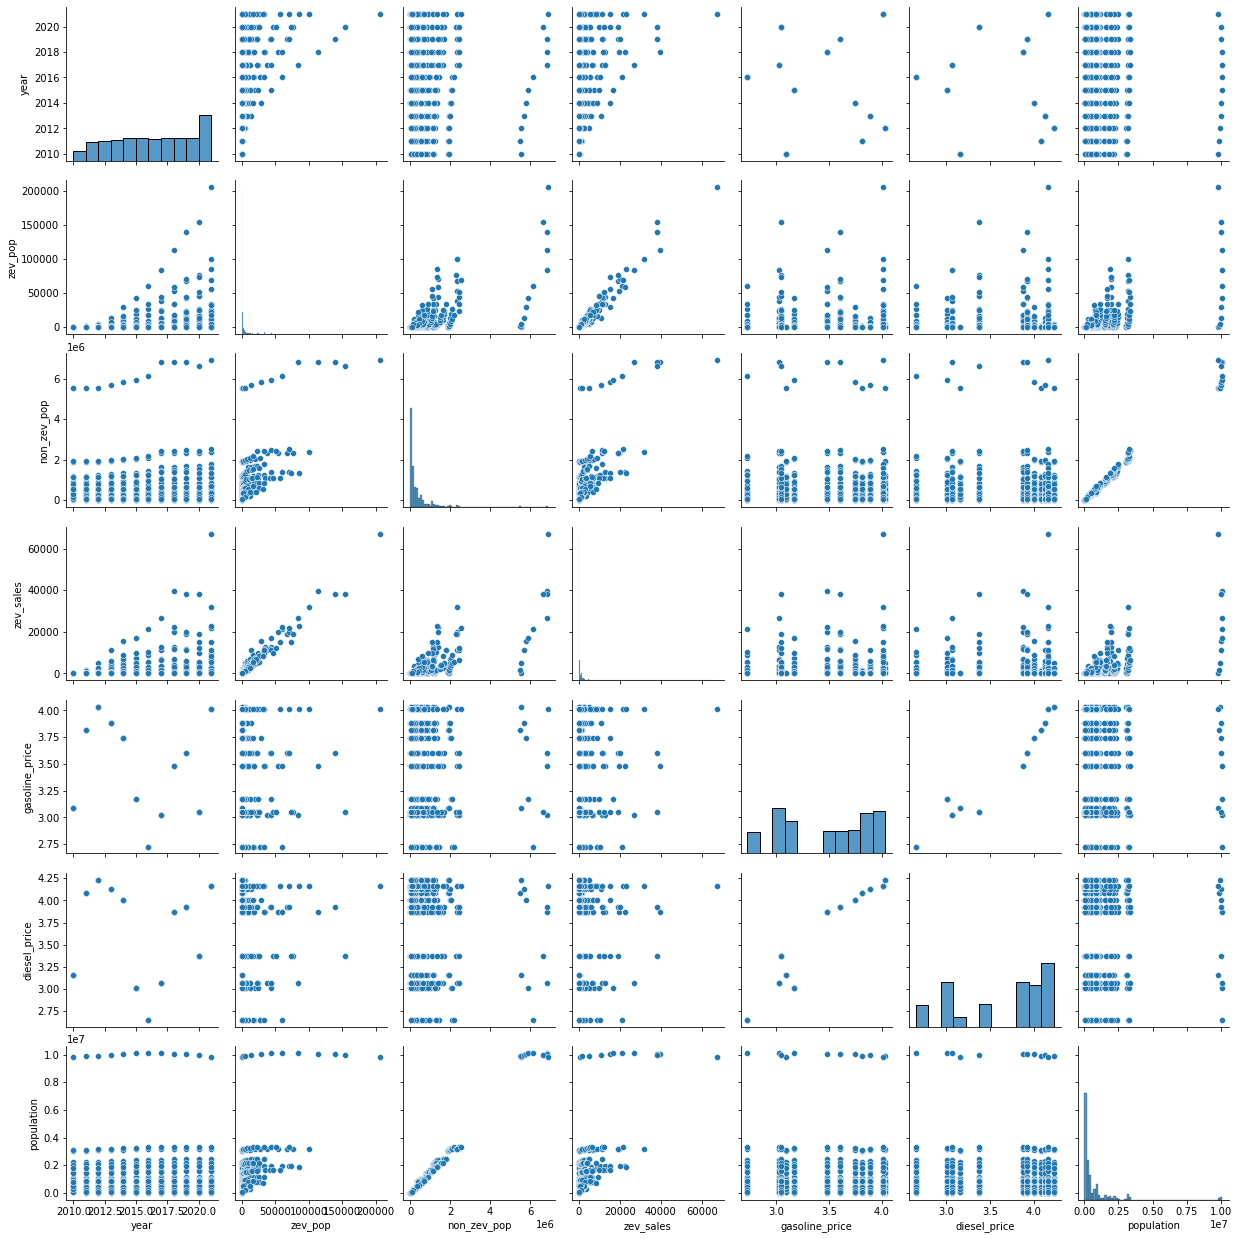

In [34]:
# Create a pair plot 
pair = sns.pairplot(df_merged)

ZEV population and ZEV sales combining with year show similar and clear trend to indicate development of ZEV. It worths to further explore to reveal the ZEV trend. Also it's interesting to compare with the trend of non_ZEV population.

#### Use a histogram to visualize the distribution of the variables.

<AxesSubplot:xlabel='gasoline_price', ylabel='Count'>

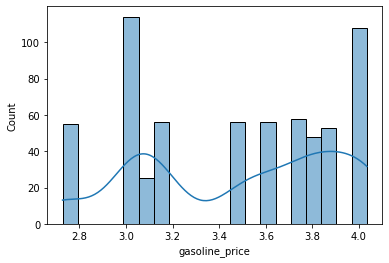

In [36]:
sns.histplot(df_merged['gasoline_price'], bins = 20, kde = True)

Gasoline prices were between $2.8 to $4 in the observed years. $3 and $4 were the most frenquent prices appeared.

According to the data exploration above, some questions can be answered as below:
1. ZEV sales increases over time. (Will be explored further later).
4. ZEV population is strong positive correlated to demographic.
5. ZEV sales is not impacted by fuel prices.

Alternative hypothesis: the counties that have higher amounts of EV Chargers would have higher sales of ZEV
Null hypothesis: the counties that have lower amount of EV Chargers would have higher sales than the counties have lower EV Chargers